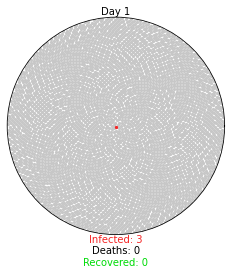

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import numpy as np

GREY = (0.78, 0.78, 0.78)  # uninfected
RED = (0.96, 0.15, 0.15)   # infected
GREEN = (0, 0.86, 0.03)    # recovered
BLACK = (0, 0, 0)          # dead

COVID19_PARAMS = {
    "r0": 2.28,
    "incubation": 5,
    "percent_mild": 0.8,
    "mild_recovery": (7, 14),
    "percent_severe": 0.2,
    "severe_recovery": (21, 42),
    "severe_death": (14, 56),
    "fatality_rate": 0.034,
    "serial_interval": 7
}


class Virus():
    def __init__(self, params):
        # create plot
        self.fig = plt.figure()
        self.axes = self.fig.add_subplot(111, projection="polar")
        self.axes.grid(False)
        self.axes.set_xticklabels([])
        self.axes.set_yticklabels([])
        self.axes.set_ylim(0, 1)

        # create annotations
        self.day_text = self.axes.annotate(
            "Day 0", xy=[np.pi / 2, 1], ha="center", va="bottom")
        self.infected_text = self.axes.annotate(
            "Infected: 0", xy=[3 * np.pi / 2, 1], ha="center", va="top", color=RED)
        self.deaths_text = self.axes.annotate(
            "\nDeaths: 0", xy=[3 * np.pi / 2, 1], ha="center", va="top", color=BLACK)
        self.recovered_text = self.axes.annotate(
            "\n\nRecovered: 0", xy=[3 * np.pi / 2, 1], ha="center", va="top", color=GREEN)

        # create member variables
        self.day = 0
        self.total_num_infected = 0
        self.num_currently_infected = 0
        self.num_recovered = 0
        self.num_deaths = 0
        self.r0 = params["r0"]
        self.percent_mild = params["percent_mild"]
        self.percent_severe = params["percent_severe"]
        self.fatality_rate = params["fatality_rate"]
        self.serial_interval = params["serial_interval"]

        self.mild_fast = params["incubation"] + params["mild_recovery"][0]
        self.mild_slow = params["incubation"] + params["mild_recovery"][1]
        self.severe_fast = params["incubation"] + params["severe_recovery"][0]
        self.severe_slow = params["incubation"] + params["severe_recovery"][1]
        self.death_fast = params["incubation"] + params["severe_death"][0]
        self.death_slow = params["incubation"] + params["severe_death"][1]

        self.mild = {i: {"thetas": [], "rs": []} for i in range(self.mild_fast, 365)}
        self.severe = {
            "recovery": {i: {"thetas": [], "rs": []} for i in range(self.severe_fast, 365)},
            "death": {i: {"thetas": [], "rs": []} for i in range(self.death_fast, 365)}
        }

        self.exposed_before = 0
        self.exposed_after = 1

        self.initial_population()


    def initial_population(self):
        population = 4500
        self.num_currently_infected = 1
        self.total_num_infected = 1
        indices = np.arange(0, population) + 0.5
        self.thetas = np.pi * (1 + 5**0.5) * indices
        self.rs = np.sqrt(indices / population)
        self.plot = self.axes.scatter(self.thetas, self.rs, s=5, color=GREY)
        # patient zero
        self.axes.scatter(self.thetas[0], self.rs[0], s=5, color=RED)
        self.mild[self.mild_fast]["thetas"].append(self.thetas[0])
        self.mild[self.mild_fast]["rs"].append(self.rs[0])


    def spread_virus(self, i):
        self.exposed_before = self.exposed_after
        if self.day % self.serial_interval == 0 and self.exposed_before < 4500:
            self.num_new_infected = round(self.r0 * self.total_num_infected)
            self.exposed_after += round(self.num_new_infected * 1.1)
            if self.exposed_after > 4500:
                self.num_new_infected = round((4500 - self.exposed_before) * 0.9)
                self.exposed_after = 4500
            self.num_currently_infected += self.num_new_infected
            self.total_num_infected += self.num_new_infected
            self.new_infected_indices = list(
                np.random.choice(
                    range(self.exposed_before, self.exposed_after),
                    self.num_new_infected,
                    replace=False))
            thetas = [self.thetas[i] for i in self.new_infected_indices]
            rs = [self.rs[i] for i in self.new_infected_indices]
            self.anim.event_source.stop()
            if len(self.new_infected_indices) > 24:
                size_list = round(len(self.new_infected_indices) / 24)
                theta_chunks = list(self.chunks(thetas, size_list))
                r_chunks = list(self.chunks(rs, size_list))
                self.anim2 = ani.FuncAnimation(
                    self.fig,
                    self.one_by_one,
                    interval=50,
                    frames=len(theta_chunks),
                    fargs=(theta_chunks, r_chunks, RED))
            else:
                self.anim2 = ani.FuncAnimation(
                    self.fig,
                    self.one_by_one,
                    interval=50,
                    frames=len(thetas),
                    fargs=(thetas, rs, RED))
            self.assign_symptoms()

        self.day += 1

        self.update_status()
        self.update_text()


    def one_by_one(self, i, thetas, rs, color):
        self.axes.scatter(thetas[i], rs[i], s=5, color=color)
        if i == (len(thetas) - 1):
            self.anim2.event_source.stop()
            self.anim.event_source.start()


    def chunks(self, a_list, n):
        for i in range(0, len(a_list), n):
            yield a_list[i:i + n]


    def assign_symptoms(self):
        num_mild = round(self.percent_mild * self.num_new_infected)
        num_severe = round(self.percent_severe * self.num_new_infected)
        # choose random subset of newly infected to have mild symptoms
        self.mild_indices = np.random.choice(self.new_infected_indices, num_mild, replace=False)
        # assign the rest severe symptoms, either resulting in recovery or death
        remaining_indices = [i for i in self.new_infected_indices if i not in self.mild_indices]
        percent_severe_recovery = 1 - (self.fatality_rate / self.percent_severe)
        num_severe_recovery = round(percent_severe_recovery * num_severe)
        self.severe_indices = []
        self.death_indices = []
        if remaining_indices:
            self.severe_indices = np.random.choice(remaining_indices, num_severe_recovery, replace=False)
            self.death_indices = [i for i in remaining_indices if i not in self.severe_indices]

        # assign recovery/death day
        low = self.day + self.mild_fast
        high = self.day + self.mild_slow
        for mild in self.mild_indices:
            recovery_day = np.random.randint(low, high)
            mild_theta = self.thetas[mild]
            mild_r = self.rs[mild]
            self.mild[recovery_day]["thetas"].append(mild_theta)
            self.mild[recovery_day]["rs"].append(mild_r)
        low = self.day + self.severe_fast
        high = self.day + self.severe_slow
        for recovery in self.severe_indices:
            recovery_day = np.random.randint(low, high)
            recovery_theta = self.thetas[recovery]
            recovery_r = self.rs[recovery]
            self.severe["recovery"][recovery_day]["thetas"].append(recovery_theta)
            self.severe["recovery"][recovery_day]["rs"].append(recovery_r)
        low = self.day + self.death_fast
        high = self.day + self.death_slow
        for death in self.death_indices:
            death_day = np.random.randint(low, high)
            death_theta = self.thetas[death]
            death_r = self.rs[death]
            self.severe["death"][death_day]["thetas"].append(death_theta)
            self.severe["death"][death_day]["rs"].append(death_r)


    def update_status(self):
        if self.day >= self.mild_fast:
            mild_thetas = self.mild[self.day]["thetas"]
            mild_rs = self.mild[self.day]["rs"]
            self.axes.scatter(mild_thetas, mild_rs, s=5, color=GREEN)
            self.num_recovered += len(mild_thetas)
            self.num_currently_infected -= len(mild_thetas)
        if self.day >= self.severe_fast:
            rec_thetas = self.severe["recovery"][self.day]["thetas"]
            rec_rs = self.severe["recovery"][self.day]["rs"]
            self.axes.scatter(rec_thetas, rec_rs, s=5, color=GREEN)
            self.num_recovered += len(rec_thetas)
            self.num_currently_infected -= len(rec_thetas)
        if self.day >= self.death_fast:
            death_thetas = self.severe["death"][self.day]["thetas"]
            death_rs = self.severe["death"][self.day]["rs"]
            self.axes.scatter(death_thetas, death_rs, s=5, color=BLACK)
            self.num_deaths += len(death_thetas)
            self.num_currently_infected -= len(death_thetas)


    def update_text(self):
        self.day_text.set_text("Day {}".format(self.day))
        self.infected_text.set_text("Infected: {}".format(self.num_currently_infected))
        self.deaths_text.set_text("\nDeaths: {}".format(self.num_deaths))
        self.recovered_text.set_text("\n\nRecovered: {}".format(self.num_recovered))


    def gen(self):
        while self.num_deaths + self.num_recovered < self.total_num_infected:
            yield


    def animate(self):
        self.anim = ani.FuncAnimation(
            self.fig,
            self.spread_virus,
            frames=self.gen,
            repeat=True)


def main():
    coronavirus = Virus(COVID19_PARAMS)
    coronavirus.animate()
    plt.show()


if __name__ == "__main__":
    main()